# ptyLab introduction (FP)

ptyLab is a highly modular coding package which can be used for both conventional and Fourier ptychography. Due to the modular nature it is easy to modify the code for various tasks and add your own functions, such as a new reconstruction engine or a calibration routine. To understand ptyLab we need to understand the basic classes contained within, which are briefly outlined below:


 -  ExperimentalData - this class is used to import the experimental data from an .hdf5 file. If the file contains the experimental images stored as an image stack (called ptychogram), probe/LED positions and several experimental parameters, then the data can be successfully imported and reconstructed.
 -  Reconstruction - this class creates various objects from the immutable ExperimentalData class which will be optimized/updated i.e. are mutable. 
 -  Params - this class stores parameters use for the reconstruction such that they could be exported/imported for different experiments
 -  Engines - all the engines used for the reconstruction are based on this class, which take the ExperimentalData and Optimizable objects as parameters and perform object/probe/pupil reconstruction.
 -  Monitor - visualization class used to display the reconstruction process
 -  CalibrationFPM - this package contains k-space position calibration routines caused by misaligned LED positions.


In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
from PtyLab.io import getExampleDataFolder
from PtyLab import Engines
import PtyLab

Cannot use pyqtgraph
Pyqtgraph not available
cupy not avialable
Cupy unavailable
Cupy not available, will not be able to run GPU based computation
Cupy not available, will not be able to run GPU based computation
Cupy not available, will not be able to run GPU based computation
Cupy not available, will not be able to run GPU based computation
Cupy not available, will not be able to run GPU based computation
Cupy not available, will not be able to run GPU based computation
Cupy not available, will not be able to run GPU based computation
Cupy not available, will not be able to run GPU based computation
Cupy not available, will not be able to run GPU based computation
Cupy not available, will not be able to run GPU based computation
Cupy not available, will not be able to run GPU based computation
Cupy not available, will not be able to run GPU based computation


In [3]:
fileName = 'LungCarcinomaFPM.hdf5'
# fileName = 'USAFTargetFPM.hdf5'
filePath = getExampleDataFolder() / fileName

exampleData, reconstruction, params, monitor, engine, calib = PtyLab.easyInitialize(filePath, operationMode='FPM')

Copying attribute wavelength
Copying attribute dxd
Copying attribute zled
Copying attribute NA


Found encoder with shape (81, 2)
"Unable to open object (object 'orientation' doesn't exist)"


## ExperimentalData class
The data must be stored as a ".hdf5" file, which enables structured file storage. For ptychographic data, experimental parameters such as wavelength or pixel size can be convieniently stored together with illumination/ecoder positions and the actual raw images/diffraction data in a single file.

A minimal list of fields required for ptyLab to work are:
- ptychogram - 3D image/diffraction data stack 
- wavelength - illumination lambda
- encoder - encoder positions / illumination angles
- dxd - detector pixel size
- zled - illumination-to-sample propagation distance
- magnification - magnification of the microscope

Also we have optional fields because they will either be computed later from the "required_fields" or are required for FPM, but not CPM (or vice-versa). If not provided by the user they will be set as None.
- NA -  numerical aperture of the microscope

The ".hdf5" file must contain a field called "ptychogram" containing the experimental raw images as a 3D array of shape [numFrames,X,Y], where numFrames is the number of images corresponding to each illumination vector in the "encoder" and X-Y are the 2D image dimensions. 

The ".hdf5" file must have a field called "encoder" containing the translation stage positions in units of meters (for CP) or the illumination angles in units of rad (for FP). The field "encoder" has a 2D shape [numFrames,2], where numFrames is the number of positions.

We start off our demonstration by creating the ExperimentalData() class which is used to load the .hdf5 file. In this example the variable "exampleData" will contain our class.

In [4]:
mean_img = np.mean(exampleData.ptychogram,0)

## Reconstruction class
The ExperimentalData class contains immutable values. The Reconstruction class creates an object which will be mutable during the reconstruction or calibration procedure. It contains the reconstructed object and the probe/pupil. 

In FPM the intial object estimate can be computed from the raw data. "reconstruction.initialObject = 'upsampled'" will take the low-resolution raw data and create an upsampled object estimate via interpolation. The probe/pupil is set to be a clear circle representing a fully transparent aperture without any aberration. Once everything is set use "initializeObjectProbe()" method.

In [5]:
reconstruction.initialProbe = 'circ'
reconstruction.initialObject = 'upsampled'
reconstruction.initializeObjectProbe()

import copy
reconstruction0 = copy.deepcopy(reconstruction)

## Monitor class
This class will create a monitor to visualize the reconstruction. 

In [6]:
# Set monitor properties
monitor.figureUpdateFrequency = 10
monitor.objectPlot = 'complex'  
monitor.verboseLevel = 'low'
monitor.objectPlotZoom = .01 
monitor.probePlotZoom = .01 

## Params class
This class holds various switches and parameters that can be specified before a reconstruction is carried out. For instance to determine whether the reconstruction is carried out on CPU or GPU, or to specify the order of probe positions to be random or sequential.

In [7]:
params.gpuSwitch = False
params.positionOrder = 'NA'
params.probeBoundary = True
params.adaptiveDenoisingSwitch = True

## IlluminationCalibration class
Calibration class based on "Regina Eckert, Zachary F. Phillips, and Laura Waller, "Efficient illumination angle self-calibration in Fourier ptychography," Appl. Opt. 57, 5434-5442 (2018)"

Radius 30.960488594993688px, iteration 0
Radius 29.460488594993688px, iteration 1
Radius 29.460488594993688px, iteration 2
Initial radius was 30.96px
Calibrated radius is 29.46px
Initial NA was 0.067
Calibrated NA is 0.064


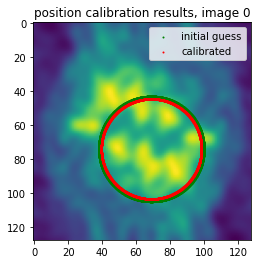

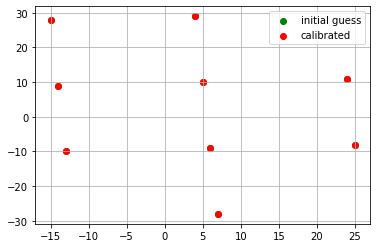

<SimilarityTransform(matrix=
    [[ 1.05173803,  0.00385589, -0.76582643],
     [-0.00385589,  1.05173803,  0.75903545],
     [ 0.        ,  0.        ,  1.        ]]) at 0x1a75e1c4880>

In [8]:
calib.plot = True
calib.fit_mode ='SimilarityTransform'
calib.calibrateRadius = True
calib.runCalibration()

## Engine class
A specific engine can be imported (e.g. ePIE, mPIE etc.) and used on the reconstruction class to optimize our initial estimates for the object/probe. In this example we use the quasi-Newton method to reconstruct the data, by passing the reconstruction, exampleData and monitor objects to be used during the reconstruction

c:\users\aiduka_t\switchdrive\ptylab\ptylab.py\PtyLab\Engines\BaseEngine.py:378: UserWarning: fftshiftSwitch set to false, this may lead to reduced performance
  warnings.warn(
c:\users\aiduka_t\switchdrive\ptylab\ptylab.py\PtyLab\Monitor\Plots.py:171: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.figure.show()


qNewton: 100%|███████████████████████████████| 200/200 [00:50<00:00,  3.94it/s]


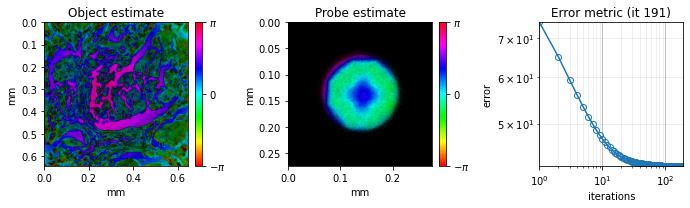

In [9]:
engine = Engines.qNewton(reconstruction, exampleData, params, monitor)
engine.numIterations = 200
engine.reconstruct()

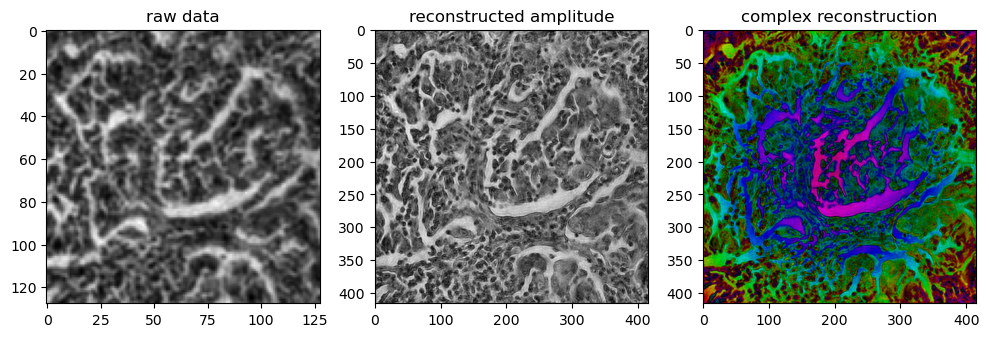

In [10]:
from PtyLab.utils.utils import fft2c, ifft2c
from PtyLab.utils.visualisation import modeTile, complex2rgb
plt.rcParams['figure.figsize'] = [12, 12]
plt.rcParams['figure.dpi'] = 100 

plt.subplot(131)
plt.title('raw data')
plt.imshow(abs(mean_img),cmap='gray')
plt.subplot(132)
plt.title('reconstructed amplitude')
plt.imshow(abs(modeTile(fft2c(reconstruction.object))),cmap='gray')
plt.subplot(133)
plt.title('complex reconstruction')
plt.imshow(complex2rgb(modeTile(fft2c(reconstruction.object))))

# Phase curvature correction in Fourier ptychography
Phase curvature in the complex plot is present because a non-telecentric imaging systems was used to acquire the data. There is also an additional curvature due to illumination. Both were described in https://doi.org/10.1364/OE.458657. 

The algorithm outlined in https://doi.org/10.1364/OE.458657 initializes the object with a phase curvature and removes it post reconstruction. In doing so, artefact free reconstruction is obtained together with improved convergence.

First, compute the combined phase curvature term due to non-telecentricity and illumination.

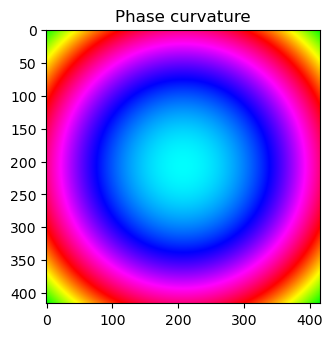

In [11]:
wavelength = reconstruction.wavelength
Np = reconstruction.Np
No = reconstruction.No
dxp = reconstruction.dxp
z=120e-3 # illumination to sample distance
u=60e-3 # sample to lens distance

# create the coordinate grid
x = np.linspace(-Np / 2 , Np / 2, No) 
Yp, Xp = np.meshgrid(x, x)
Yp = Yp*dxp
Xp = Xp*dxp

# illumination phase curvature
ill_curvature = np.exp(1j*np.pi/wavelength * (1/z) * (Xp**2 + Yp**2))
# non-telecentricity induced phase curvature
tele_curvature = np.exp(1j*np.pi/wavelength * (1/u) * (Xp**2 + Yp**2))
# combined curvature
total_curvature = ill_curvature * tele_curvature

plt.subplot(132)
plt.title('Phase curvature')
plt.imshow(complex2rgb(total_curvature))

Now initialize the object with the phase curvature, reconstruct and remove it.

In [13]:
# Initialize the object + curvature
reconstruction = copy.deepcopy(reconstruction0)
reconstruction.object = ifft2c(fft2c(reconstruction.object) * total_curvature.conj())

# Reconstruct
engine = Engines.qNewton(reconstruction, exampleData, params, monitor)
engine.numIterations = 200
engine.reconstruct()

# Remove the curvature
fixed_object = modeTile(fft2c(reconstruction.object) * total_curvature);

qNewton: 100%|███████████████████████████████| 200/200 [01:09<00:00,  2.86it/s]


The resulting reconstruction is free from phase artefacts and benefits from faster convergence.

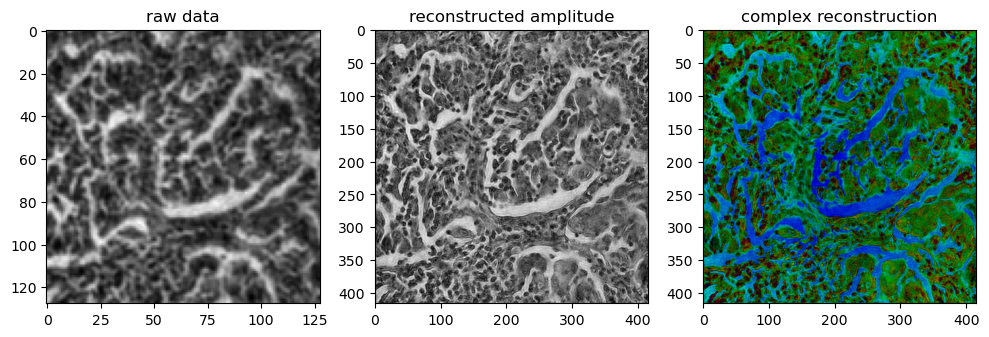

In [15]:
plt.subplot(131)
plt.title('raw data')
plt.imshow(abs(mean_img),cmap='gray')
plt.subplot(132)
plt.title('reconstructed amplitude')
plt.imshow(abs(fixed_object),cmap='gray')
plt.subplot(133)
plt.title('complex reconstruction')
plt.imshow(complex2rgb(fixed_object))